<a href="https://colab.research.google.com/github/haeniKim/multi_project3/blob/master/CNN_Snack_1_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 모델 생성
### 과자 10종 분류 모델
* Train_Data : 1040
* Valid_Data : 250

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

# I. Google Drive Mount
* 이미지 데이터 불러오기

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# II. Data Preprocessing

> ## 1) Create Image_File DataFrame

In [ ]:
dir_ = Path('/content/drive/MyDrive/Colab Notebooks/datasets/new_snack')
filepaths = list(dir_.glob(r'**/*.jpg'))

def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head()

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/dataset...,heim
1,/content/drive/MyDrive/Colab Notebooks/dataset...,oreo
2,/content/drive/MyDrive/Colab Notebooks/dataset...,pepero
3,/content/drive/MyDrive/Colab Notebooks/dataset...,pie
4,/content/drive/MyDrive/Colab Notebooks/dataset...,pepero


## 2) Data EDA

In [ ]:
print('The number of pictures:', df.shape[0])
print('The number of snacks:', len(df.Label.unique()))
print('Labels:', df.Label.unique())

The number of pictures: 1290
The number of snacks: 10
Labels: ['heim' 'oreo' 'pepero' 'pie' 'chip' 'banana' 'shrimp' 'onion' 'pizza'
 'turtle']


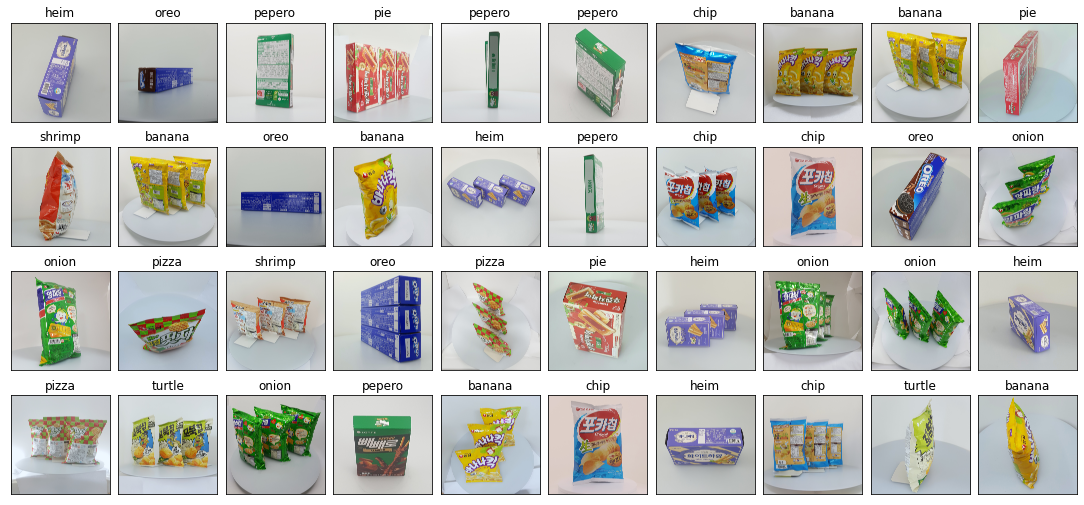

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

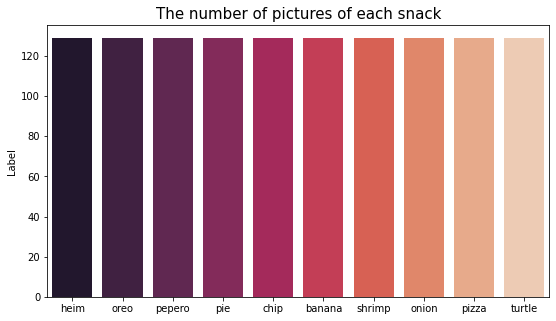

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("The number of pictures of each snack", fontsize = 15)
plt.show()

## 3) Train / Test Split (수정 필요 - 필요 있는지 없는지)

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((1161, 2), (129, 2))

## 4) ImageDataGenerator( ) & flow_from_directory( )

* Normalization
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_directory( )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/datasets/new_snack',
                                                 target_size = (75, 75),
                                                 batch_size = 6,
                                                 class_mode = 'categorical',subset='training')
valid_generator  = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/datasets/new_snack',
                                                 target_size = (75, 75),
                                                 batch_size = 6,
                                                 class_mode = 'categorical',subset='validation')


Found 1040 images belonging to 10 classes.
Found 250 images belonging to 10 classes.


> ## 4) Test train_generator

In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (6, 75, 75, 3)
배치 레이블 크기: (6, 10)


In [ ]:
labels_batch

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# III. CNN Keras Modeling

> ## 1) Model Define

* Feature Extraction & Classification

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (75, 75, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

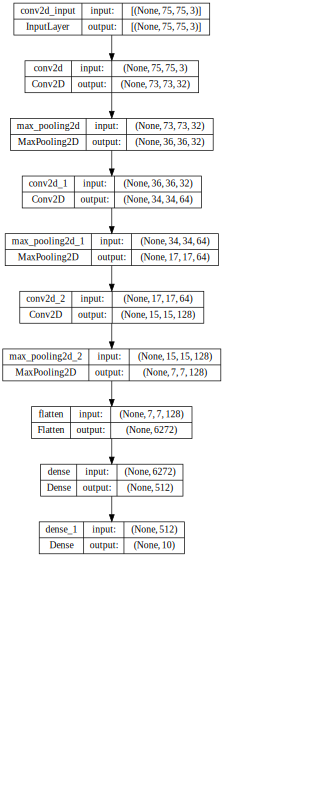

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

dot_res = model_to_dot(model,show_shapes=True, dpi=50).create(prog='dot', format='svg')
fi = open("model_cnn_1.svg", 'wb')
fi.write(dot_res)
fi.close()

SVG(dot_res)



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 128)        0

> ## 2) Model Compile

* 모델 학습방법 설정

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 37분 소요

In [ ]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 19,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 3)

Epoch 1/100
19/19 [==============================] - 58s 3s/step - loss: 2.2090 - accuracy: 0.1491 - val_loss: 1.7527 - val_accuracy: 0.3333
Epoch 2/100
19/19 [==============================] - 54s 3s/step - loss: 1.8471 - accuracy: 0.2544 - val_loss: 2.0455 - val_accuracy: 0.2778
Epoch 3/100
19/19 [==============================] - 46s 2s/step - loss: 1.3856 - accuracy: 0.4825 - val_loss: 1.0070 - val_accuracy: 0.5000
Epoch 4/100
19/19 [==============================] - 48s 3s/step - loss: 1.0021 - accuracy: 0.6140 - val_loss: 0.8430 - val_accuracy: 0.6111
Epoch 5/100
19/19 [==============================] - 36s 2s/step - loss: 0.6437 - accuracy: 0.7193 - val_loss: 0.7425 - val_accuracy: 0.6667
Epoch 6/100
19/19 [==============================] - 39s 2s/step - loss: 0.7198 - accuracy: 0.6930 - val_loss: 1.2991 - val_accuracy: 0.5000
Epoch 7/100
19/19 [==============================] - 29s 2s/step - loss: 0.7787 - accuracy: 0.7719 - val_loss: 0.7238 - val_accuracy: 0.5556
Epoch 8/100
1

> ## 4) Loss & Accuracy Visualization

* Loss Visualization

In [ ]:
print(Hist_dandc.history['val_loss'])
print(Hist_dandc.history['loss'])

[1.7526895999908447, 2.0455312728881836, 1.0069819688796997, 0.8429647088050842, 0.7425049543380737, 1.2991137504577637, 0.7237732410430908, 0.9876686930656433, 0.3787592649459839, 0.7646096348762512, 0.17691609263420105, 0.2429846078157425, 0.6965312361717224, 0.49162557721138, 0.4007187485694885, 0.3405627906322479, 0.17990237474441528, 0.04974530637264252, 0.6359743475914001, 1.1153596639633179, 0.7500447034835815, 0.517379879951477, 0.4178115129470825, 0.3678840100765228, 1.3510394096374512, 0.21472591161727905, 0.13750547170639038, 0.31904035806655884, 0.08162371069192886, 0.07103978842496872, 0.6291773915290833, 0.5713503956794739, 0.017615308985114098, 0.46220266819000244, 0.22991807758808136, 1.3165510892868042, 0.33244964480400085, 0.4003823399543762, 1.0272259712219238, 0.4872628450393677, 0.18336646258831024, 0.06988390535116196, 1.2548872232437134, 0.31589996814727783, 0.4770682752132416, 0.3893721103668213, 0.32836318016052246, 0.4711436629295349, 0.1431475281715393, 1.108

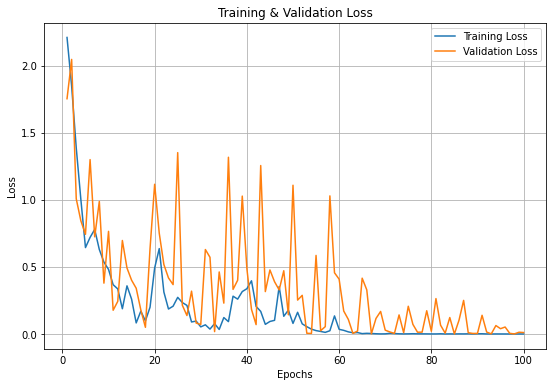

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

* Accuracy Visualization

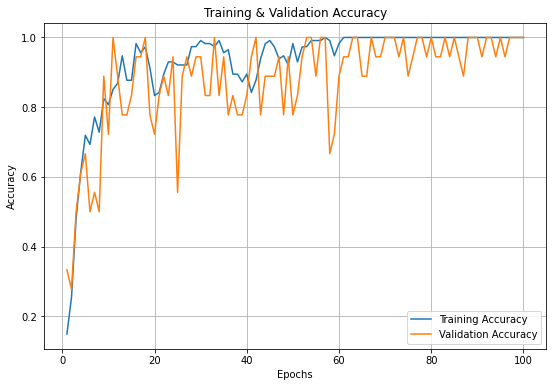

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate (test 수정 필요)
1. 기존 강사님 코드에서는 test를 디렉토리에서 분리
2. 성능 100코드는 cnn 모델 테스트에 test 사용 안함.

* test_generator

In [ ]:
# 수정 필요1
test_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

test_images = test_generator.flow_from_dataframe(
          dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=10,
        shuffle=False
    )
    

Found 129 validated image filenames belonging to 10 classes.


In [ ]:
# 수정 필요2
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (75, 75),
                 batch_size = 6,
                 class_mode = 'categorical')

* Loss & Accuracy

In [ ]:
#수정 필요 3
pred = model.predict(test_images)

InvalidArgumentError: ignored

In [ ]:
#수정 필요 4
loss, accuracy = model.evaluate(test_images,
                                steps = 22)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

InvalidArgumentError: ignored

## 6) Model Saving

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/models/snack_cnn_1.h5')

In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 294548
-rw------- 1 root root     35432 Oct  7 08:23 001_Model_iris.h5
-rw------- 1 root root  41499528 Oct 12 04:46 002_dogs_and_cats_small.h5
-rw------- 1 root root 140748848 Oct 13 01:27 005_dogs_and_cats_fine_tuning.h5
-rw------- 1 root root  39777040 Nov 21 06:30 snack_1.h5
-rw------- 1 root root  39777040 Nov 17 01:55 snack_2.h5
-rw------- 1 root root  39777040 Nov 21 06:31 snack_cnn_1.h5


### 7) Model Load

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

model_1 = load_model('/content/drive/My Drive/Colab Notebooks/models/snack_cnn_1.h5')